In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


In [8]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train shape: ", train.shape)
print("Test shape: ", test.shape)
train.head(3)

Train shape:  (1460, 81)
Test shape:  (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [9]:
train_id = train["Id"]
test_id = test["Id"]
train.drop(["Id"], axis=1, inplace=True)
test.drop(["Id"], axis=1, inplace=True)

for col in train.columns:
    if train[col].dtype == "object":
        train[col] = train[col].fillna(train[col].mode()[0])
    else:
        train[col] = train[col].fillna(train[col].median())

for col in test.columns:
    if test[col].dtype == "object":
        test[col] = test[col].fillna(test[col].mode()[0])
    else:
        test[col] = test[col].fillna(test[col].median())


In [10]:
all_data = pd.concat([train.drop("SalePrice", axis=1),test], axis=0)
all_data = pd.get_dummies(all_data)
train_X = all_data.iloc[:train.shape[0], :]
test_X = all_data.iloc[train.shape[0]:, :]
train_y = train["SalePrice"]

print("Encoded shape:", all_data.shape)

Encoded shape: (2919, 287)


In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
print("Training set:", X_train.shape)
print("Validation set:", X_valid.shape)

Training set: (1168, 287)
Validation set: (292, 287)


In [18]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, random_state=42)
}

rmse_scores = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    r2 = r2_score(y_valid, preds)
    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    rmse_scores[name] = rmse
    print(f"{name} RMSE: {rmse:.4f}")

Linear Regression RMSE: 29557.7093
Random Forest RMSE: 28671.1611
Gradient Boosting RMSE: 26746.9328
XGBoost RMSE: 25267.7097


               Model          RMSE
0  Linear Regression  29557.709302
1      Random Forest  28671.161124
2  Gradient Boosting  26746.932797
3            XGBoost  25267.709671


/tmp/ipykernel_7714/3791975907.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="RMSE", y="Model", data=rmse_df, palette="viridis")


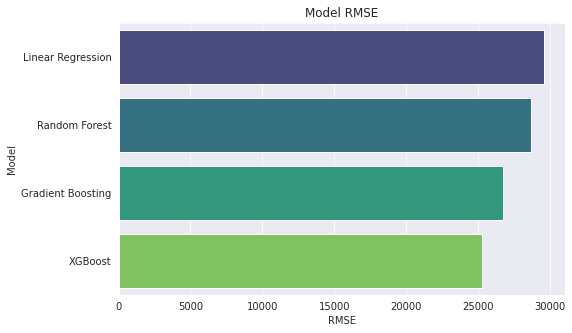

In [19]:
rmse_df = pd.DataFrame(list(rmse_scores.items()), columns=["Model", "RMSE"]).sort_values(by="RMSE", ascending=False)
print(rmse_df)

plt.figure(figsize=[8, 5])
sns.barplot(x="RMSE", y="Model", data=rmse_df, palette="viridis")
plt.title("Model RMSE")
plt.show()

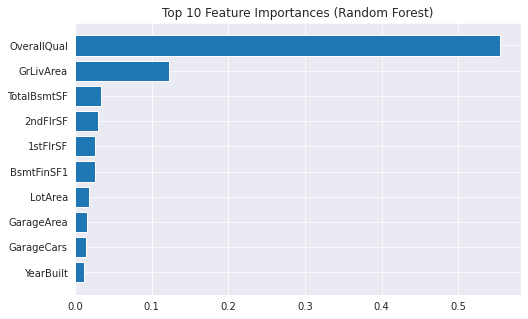

In [23]:
best_model = models["Random Forest"]
importances = best_model.feature_importances_
indices = np.argsort(importances)[-10:]

plt.figure(figsize=[8, 5])
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [train_X.columns[i] for i in indices])
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()

In [24]:
final_model = models["XGBoost"]
final_model.fit(train_X, train_y)
predictions = final_model.predict(test_X)
submission = pd.DataFrame({"Id": test_id, "SalePrice": predictions})
submission.to_csv("submission.csv", index=False)
print("Submission saved to submission.csv")

Submission saved to submission.csv
